In [ ]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


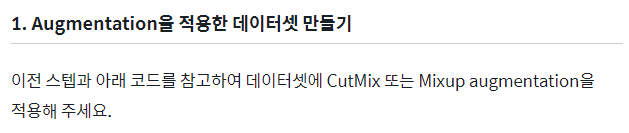

In [ ]:
!mkdir -p ~/aiffel/data_augmentation/data

In [ ]:
# Tensorflow and tf.keras

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


In [ ]:
 # gpu는 대문자로 해줘야 된다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# stanfor_dogs dataset

# tensorflow dataset에 있는 데이터
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete35FH0T/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete35FH0T/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


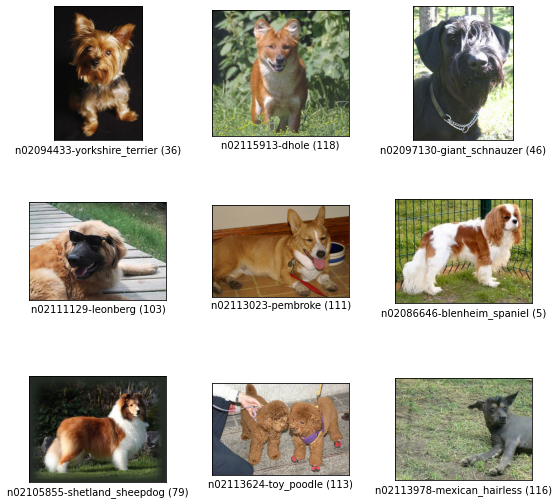

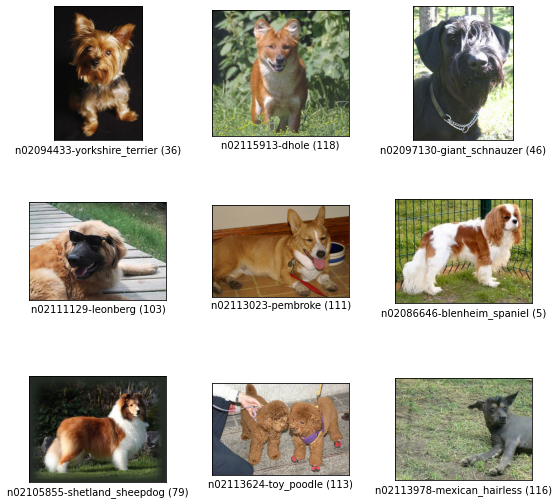

In [ ]:
# 다운로드한 데이터를 확인!
tfds.show_examples(ds_train, ds_info)

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 좌우 사진 flipping, up_down은 위아래 뒤집힌 사진이 없으므로 도움 x
    image = tf.image.random_brightness(image, max_delta=0.2) # 밝기 조절은 필수다. 실무에서도 무조건 사용해야하는 augmentation
    image = tf.clip_by_value(image, 0, 1) # 이 함수는 텐서 안의 값이 지정된 범위를 넘지 않게 해준다.
    return image, label

# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
    normalize_and_resize_img, # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
        augment, # augment 함수 적용
        num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  
    return ds

**2가지 Augmentation 기법 사용하기** 

1. Cutmix Augmentation




In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

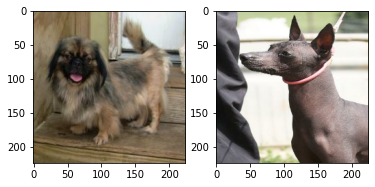

In [ ]:


# 데이터셋에서 이미지 2개를 가져오기
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

이 2가지의 이미지를 얻었는데, 첫번째 개의 이미지를 a로 한다. 바탕이 되는 이미지이다. 삽입용으로는 오른쪽 개를 넣어서, a에 삽입될 영역의 바운딩 박스의 위치를 구하는 함수를 구현해 보고자 한다.

1) 이미지 섞기

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(48, shape=(), dtype=int32) tf.Tensor(170, shape=(), dtype=int32)
y :  tf.Tensor(78, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


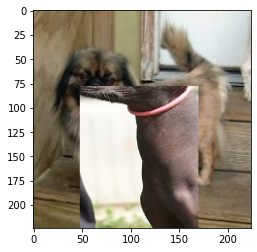

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

2) 라벨 섞기

Cutmix는 면적에 비례해서 라벨을 섞어준다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 2가지 라벨의 비율로 더해준다.

In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.6450096 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

2. Mixup Augmentation

단순하게 2개의 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식이다.

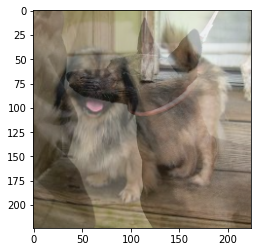

tf.Tensor(
[0.         0.         0.         0.69763136 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [ ]:
# function for mixup
num_classes = ds_info.features["label"].num_classes


def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

[tensorflow one_hot encoding 함수](https://jimmy-ai.tistory.com/100)

모델을 뒤쪽에 훈련을 해야 하는데, Cutmix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는데 사용했던 sparse_categorical_cross_entropy() 대신 categorical_crossentropy()를 사용해야 한다.

cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문이다.

In [ ]:
# label 변수를 만들고 원핫 인코딩 함수 만들기

def one_hot_encoding(image, label):
  label = tf.one_hot(label, num_classes)
  return image, label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            one_hot_encoding,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

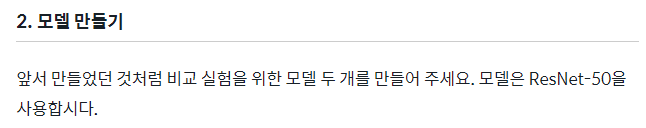

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

Total 4가지의 모델이 필요하다.

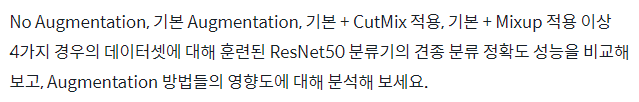

In [ ]:
# 1. No augmentation

In [ ]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # False로 했을때 fc 계층이 없음을 확인할 수 있다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 3s 0us/step


In [ ]:
# 2. 기본 augmentation

In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # False로 했을때 fc 계층이 없음을 확인할 수 있다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 3. cutmix augmentation

In [ ]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # False로 했을때 fc 계층이 없음을 확인할 수 있다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 4. mixup augmentation

In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # False로 했을때 fc 계층이 없음을 확인할 수 있다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

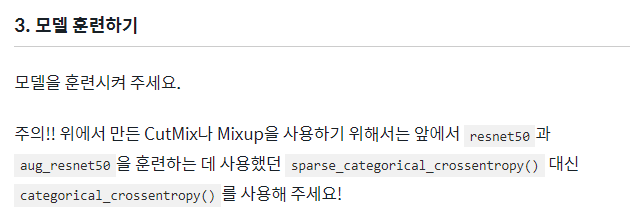

범주형 교차 엔트로피 오차 (Categorical Cross Entropy Entropy) :
범주형 교차 엔트로피 오차는 클래스가 3개 이상인 데이터를 대상으로 사용하는 손실함수이다.

One-hot 벡터 형태에서는 1 또는 0의 값이기 때문에 categorical_crossentropy를 사용한다.


In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 3

# 1. no_aug
no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
# 2. aug
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 3. cutmix
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
# 4. mixup
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_no_aug_resnet50 = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 101s 116ms/step - loss: 2.1983 - accuracy: 0.4503 - val_loss: 3.1744 - val_accuracy: 0.2409
Epoch 2/20
750/750 [==============================] - 91s 122ms/step - loss: 0.6594 - accuracy: 0.8185 - val_loss: 1.0192 - val_accuracy: 0.7011
Epoch 3/20
750/750 [==============================] - 86s 114ms/step - loss: 0.1825 - accuracy: 0.9661 - val_loss: 0.9214 - val_accuracy: 0.7275
Epoch 4/20
750/750 [==============================] - 86s 114ms/step - loss: 0.0459 - accuracy: 0.9967 - val_loss: 0.9025 - val_accuracy: 0.7417
Epoch 5/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0202 - accuracy: 0.9998 - val_loss: 0.9099 - val_accuracy: 0.7424
Epoch 6/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.9193 - val_accuracy: 0.7451
Epoch 7/20
750/750 [==============================] - 86s 114ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.9336 - val_a

In [ ]:
history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 93s 115ms/step - loss: 2.2694 - accuracy: 0.4289 - val_loss: 3.2048 - val_accuracy: 0.2203
Epoch 2/20
750/750 [==============================] - 86s 114ms/step - loss: 0.9749 - accuracy: 0.7212 - val_loss: 1.4244 - val_accuracy: 0.5967
Epoch 3/20
750/750 [==============================] - 86s 114ms/step - loss: 0.5611 - accuracy: 0.8452 - val_loss: 1.2849 - val_accuracy: 0.6322
Epoch 4/20
750/750 [==============================] - 86s 114ms/step - loss: 0.2793 - accuracy: 0.9322 - val_loss: 1.0770 - val_accuracy: 0.6974
Epoch 5/20
750/750 [==============================] - 86s 115ms/step - loss: 0.1433 - accuracy: 0.9723 - val_loss: 0.9829 - val_accuracy: 0.7218
Epoch 6/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0819 - accuracy: 0.9867 - val_loss: 0.9451 - val_accuracy: 0.7350
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0488 - accuracy: 0.9945 - val_loss: 0.9556 - val_ac

In [ ]:

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 95s 118ms/step - loss: 3.8391 - accuracy: 0.2112 - val_loss: 3.5756 - val_accuracy: 0.1806
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 2.9480 - accuracy: 0.4296 - val_loss: 1.3238 - val_accuracy: 0.6223
Epoch 3/20
750/750 [==============================] - 88s 117ms/step - loss: 2.6382 - accuracy: 0.5283 - val_loss: 1.1951 - val_accuracy: 0.6665
Epoch 4/20
750/750 [==============================] - 88s 117ms/step - loss: 2.4161 - accuracy: 0.5997 - val_loss: 1.2067 - val_accuracy: 0.6666
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 2.2838 - accuracy: 0.6441 - val_loss: 1.3958 - val_accuracy: 0.6358
Epoch 6/20
750/750 [==============================] - 88s 117ms/step - loss: 2.1440 - accuracy: 0.6892 - val_loss: 1.2112 - val_accuracy: 0.6644
Epoch 7/20
750/750 [==============================] - 88s 117ms/step - loss: 2.0373 - accuracy: 0.7197 - val_loss: 1.3339 - val_ac

In [ ]:

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 95s 118ms/step - loss: 3.7187 - accuracy: 0.2370 - val_loss: 4.0193 - val_accuracy: 0.1274
Epoch 2/20
750/750 [==============================] - 93s 124ms/step - loss: 2.8444 - accuracy: 0.4800 - val_loss: 1.4088 - val_accuracy: 0.5974
Epoch 3/20
750/750 [==============================] - 88s 117ms/step - loss: 2.5593 - accuracy: 0.5912 - val_loss: 1.3479 - val_accuracy: 0.6231
Epoch 4/20
750/750 [==============================] - 88s 117ms/step - loss: 2.3934 - accuracy: 0.6622 - val_loss: 1.2143 - val_accuracy: 0.6613
Epoch 5/20
750/750 [==============================] - 88s 117ms/step - loss: 2.2488 - accuracy: 0.7162 - val_loss: 1.2981 - val_accuracy: 0.6479
Epoch 6/20
750/750 [==============================] - 93s 124ms/step - loss: 2.1367 - accuracy: 0.7559 - val_loss: 1.3431 - val_accuracy: 0.6431
Epoch 7/20
750/750 [==============================] - 88s 118ms/step - loss: 2.1090 - accuracy: 0.7648 - val_loss: 1.2638 - val_ac

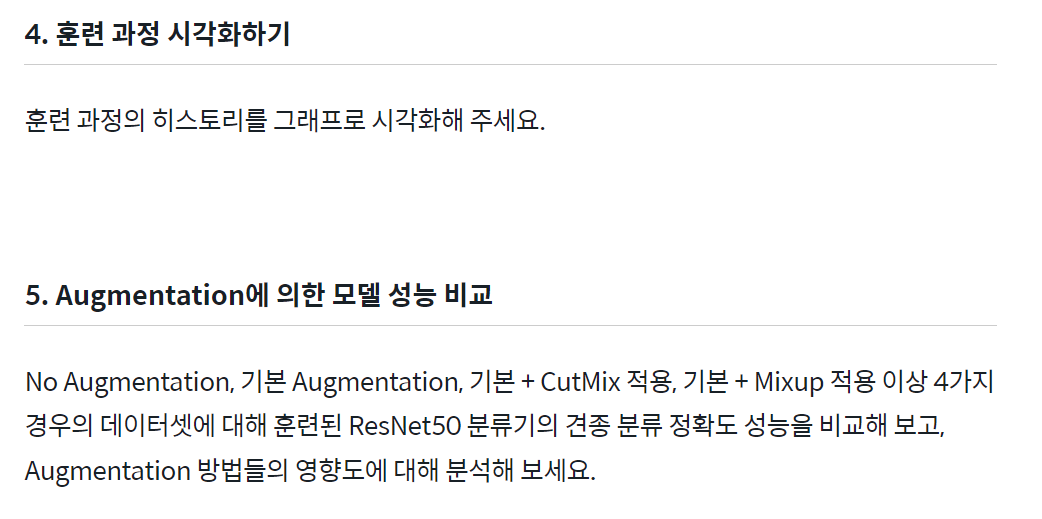

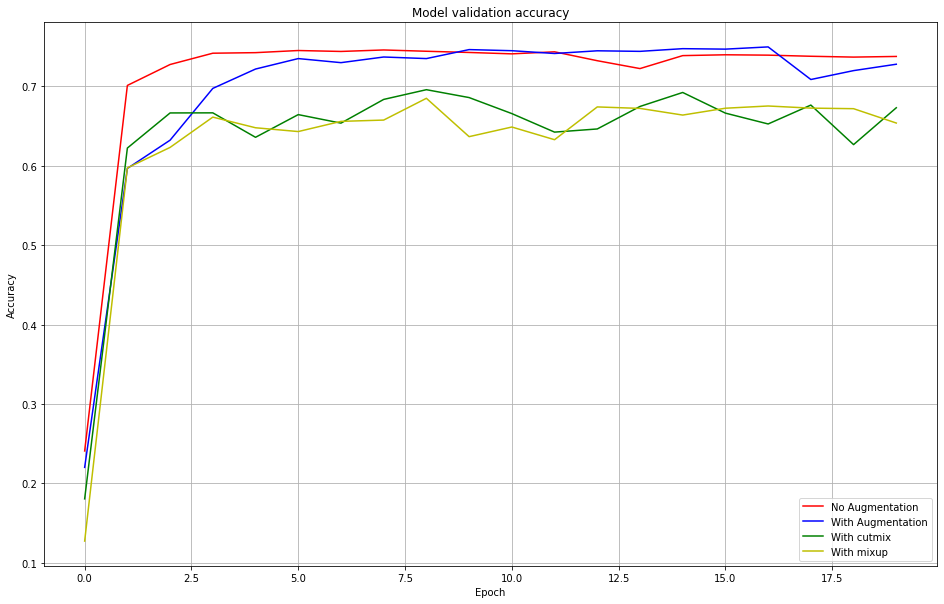

In [ ]:
plt.figure(figsize=(16,10))

plt.plot(history_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50 .history['val_accuracy'], 'g')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With cutmix', 'With mixup'], loc='lower right')

plt.grid(True)
plt.show()

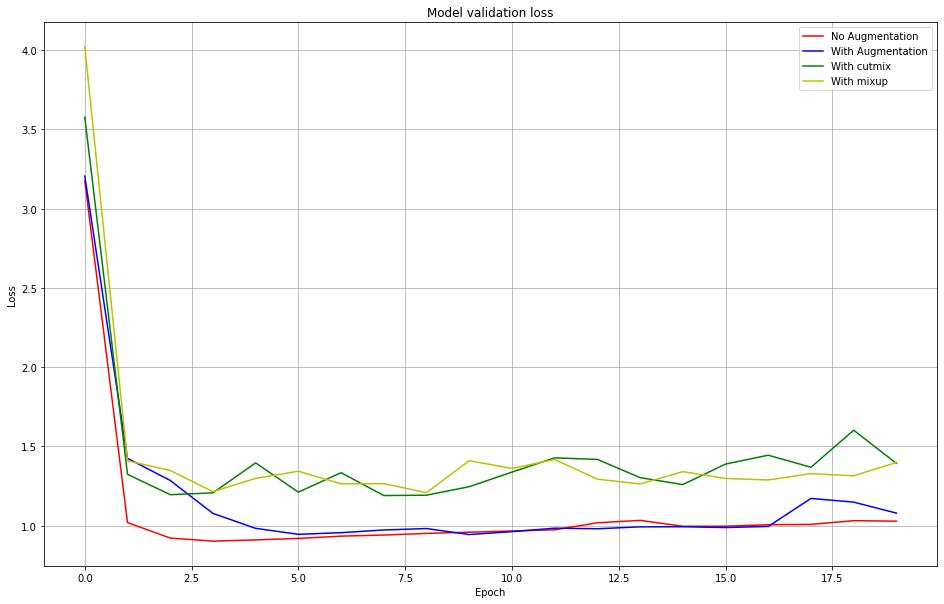

In [ ]:
plt.figure(figsize=(16,10))

plt.plot(history_no_aug_resnet50.history['val_loss'], 'r')
plt.plot(history_aug_resnet50.history['val_loss'], 'b')
plt.plot(history_cutmix_resnet50 .history['val_loss'], 'g')
plt.plot(history_mixup_resnet50.history['val_loss'], 'y')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With cutmix', 'With mixup'], loc='upper right')

plt.grid(True)
plt.show()

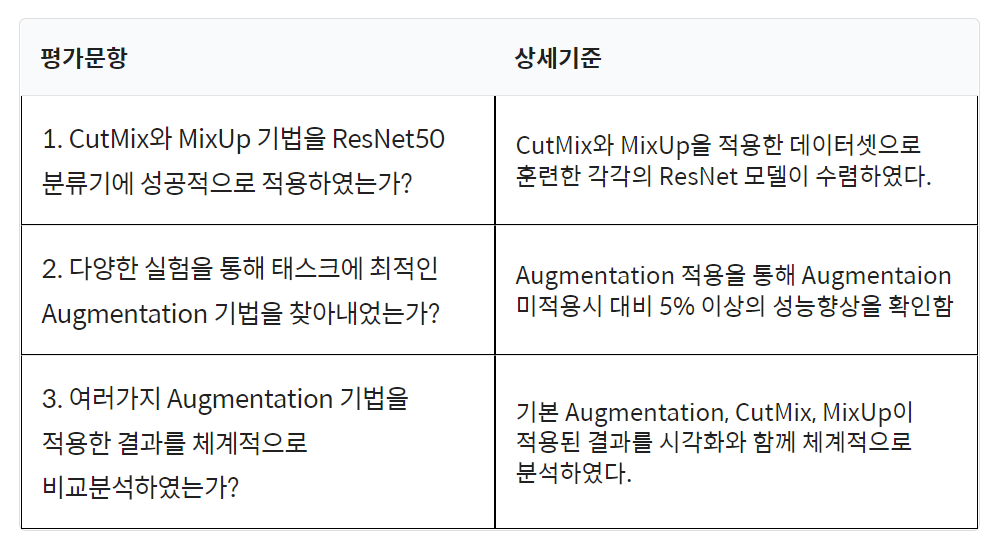

이상하게 Cutmix와 Mixup 기법을 통해서 Augmentation을 한 경우에는 5%이상의 성능향상이 아니라 10% 이하의 성능 저하가 확인 되었다.

[Cutmix, Mixup 논문정리](https://hongl.tistory.com/223)




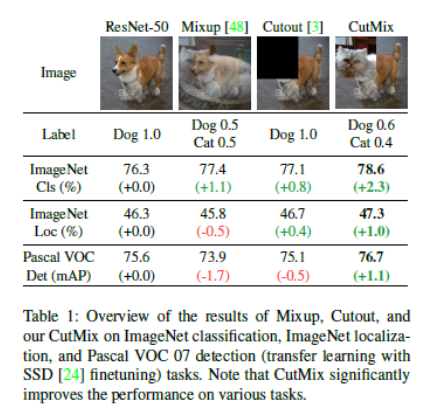

네이버 Clova에서 발표한 논문인데, 논문안 Table 1을 보면 Cutmix같은 경우에는 Imagenet 모델에서 극소한 향상을 보였고 Pascal VOC Det 데이터셋 (https://goodwoong.tistory.com/98)으로도 향상을 보였다.

반면에 Mixup같은 경우에는 ImageNET localization과 Pascal VOC Det에서는 하락을 보였다.

Mixup 같은 경우에는 논문의 fig1에서 전체 이미지를 선형 보간으로 섞었기 때문에 부자연스러워 CAM 부분이 상대적으로 넓게 나타나는 것도 확인이 가능하다.

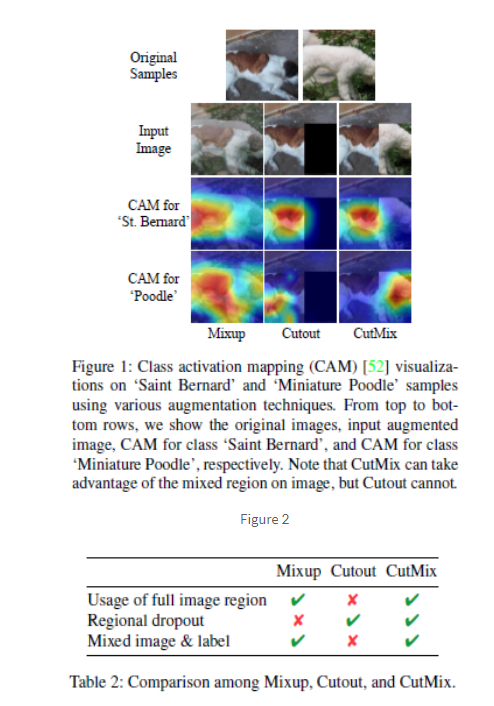



논문에서의 결론은 CutMIx기법은 성능이 가장 좋고 Mixup같은 경우에는 Cutout과 같이 성능저하가 나타난다는데, MIxup같은 경우는 수리적인 수식부분을 배제 하더라도 인간이 착시현상이나 어지러워서 두 물체가 겹쳐보인다는 그런증상으로만 생각을 해봐도 역시 딥러닝에서 학습을 시킬때 큰 혼돈을 줄수 있을꺼라고 생각이 든다.

하지만, 본 재현?에서는 Cutmix도 성능이 좋지않게 나와서 여러가지로 생각을 해보았는데, 

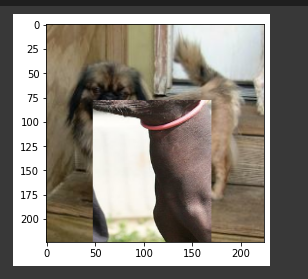

다음과 같이 객체(object)인 강아지 둘의 사진의 오려 붙인 부분이 부자연스럽다. cutmix를 하려면 강아지의 턱 부분과 몸통 부분이 어느 정도 일치를 해야 할꺼 같고, 사전적으로는 사진의 앵글과 자세 각도가 비슷한 dataset이 필요할 것이다.

그리고, Random으로 Cutmix dataset을 구현하더라도 완전히 유치원 시절에 사진오려 붙이기를 하는것처럼 두 사진의 합성이 구별할 정도는 되어야 한다고 본다.

현실적으로는 불가능에 가깝지만, 금전적으로 돈이 많이 들더라도 입맛을 충족하는 깔끔한 데이터셋을 얻는 것이 가장 중요하다고 느낀 Going_deeper라고 생각한다. 

raw 데이터를 모으는 방법은 돈 뿐만 아니라 사람의 노력과 노가다가 들어가는데, 이런 방식 또한 자동화 시킬수 있는 뭔가?가 필요해 보인다.

아직 내 능력으로는 할수도 없고 시도도 힘들어 보이지만..
그래야 진정한 인공지능-딥러닝이 아닐까 생각한다.

현재로서는 데이터 증강 방식에서 좌우 대칭이나 색깔변환이나 회전등의 전통적인?것으로 학습을 시키는 방법이 학술적인 의미를 제외한 실무적인 차원에서는 최적의 방법이고 시간을 절약하고 소기의 목적을 달성할 수 있는 방법이라고 생각한다.





